# Identification of organic compounds from their refractive index using deep learning

---
This notebook is for a model developed using Far-IR region data only



In [169]:
# Install keras
# !pip install keras==2.1.6

In [192]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#New imports
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# tf.keras.utils.to_categorical
%matplotlib inline

In [193]:
# Mounting google drive, to be able to write & read files on it
# This code block can only run on colab.research.google.com (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing our scrapped data, currently using github hosted file.
This data is a result of web scrapping "refractiveindex.info" website


In [194]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/riScrappedData.csv")
df.head()

,book,wl,n,k
0,CH4 (Methane),1.68,1.000436,NaN
1,CH4 (Methane),1.94,1.000436,NaN
2,CH4 (Methane),2.67,1.000433,NaN
3,CH4 (Methane),2.79,1.000431,NaN
4,CH4 (Methane),2.96,1.000428,NaN


# Data visualization and pre-processing

## Handling missing values

In [195]:
# Shape of the dataframe
df.shape

(248756, 4)

In [196]:
# Counting null values from each column
df.isna().sum()

book       0
wl         0
n          0
k       9645
dtype: int64

There are 9645 missing values of K

In [197]:
# Replacing all missing values of K with zero
df['k'].fillna(0, inplace = True)

In [198]:
# Confirming we have handled NUll k values
df.isna().sum()

book    0
wl      0
n       0
k       0
dtype: int64

## One hot encoding targets (Classes of organic compounds) with integers

In [199]:
# Get unique values of classes, sort them to ensure always the same order

# encode class values as integers
encoder = LabelEncoder()
df['book'] = encoder.fit_transform(df['book'])

# This is our dictionary for decoding the labels 
# (Same order as indices of probabilities from NN prediction)
classes_dictionary = dict(zip(encoder.transform(encoder.classes_), encoder.classes_,))
classes_dictionary = str(classes_dictionary) 

# Write our dictionary to a json file
import json
	
# Write to current runtime
with open("classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

# Write to google drive
with open("/content/drive/MyDrive/colab_data/DLOrganicClassifierData/classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

## Grouping data by wavelengths
i.e 'UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'

In [200]:
# Shuffling data to make it random
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,wl,n,k
0,14,2.20207,1.55291,0.000136
1,28,2.53700,1.34100,0.000222
2,29,2.01377,1.39886,0.000035
3,40,1.87243,1.54713,0.000003
4,41,1.60745,1.52109,0.000023


In [201]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,0.75,1.5,4.0, np.inf], labels= ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'])
df.sample(3)

,book,wl,n,k,wl_range
164625,33,2.91843,1.48530,0.001261,IR
73182,49,2.08034,1.51565,0.000046,IR
136241,55,1.95799,1.30760,0.000045,IR


Let’s see how many of each class is in our data set

In [202]:
df['wl_range'].value_counts()

IR         129252
Far_IR      73576
Near_IR     37853
Visible      6268
UV           1807
Name: wl_range, dtype: int64

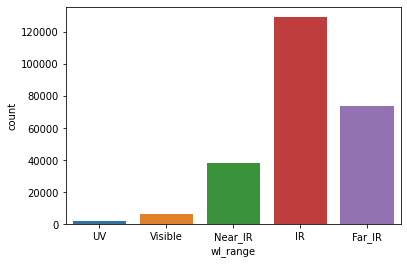

In [203]:
# Visualising
sns.countplot(x ='wl_range', data = df)

In [204]:
# Lets select only rows within Far_IR
df = df.loc[df['wl_range'].isin(['Far_IR'])]
df.head()

,book,wl,n,k,wl_range
7,6,5.29070,1.37117,0.000287,Far_IR
10,9,12.46400,1.52350,0.013900,Far_IR
17,41,9.80211,1.56141,0.050218,Far_IR
26,40,6.67132,1.50529,0.007579,Far_IR
28,42,4.35741,1.47642,0.000074,Far_IR


In [205]:
# Describe new df with only Near-Infrared data
df.describe()

,book,wl,n,k
count,73576.000000,73576.000000,73576.000000,73576.000000
mean,33.577362,8.955725,1.442561,0.017829
std,14.161079,5.749281,0.096021,0.059334
min,0.000000,4.000030,0.805570,0.000000
25%,22.000000,5.123000,1.367920,0.000574
50%,36.000000,7.071680,1.450935,0.002110
75%,46.000000,11.079000,1.512940,0.011292
max,58.000000,200.000000,2.206960,1.224330


In [206]:
df.shape

(73576, 5)

## Feature selection/extraction
Creating predictors(X) and Targets(y) for Training and testing the Deep Learning model.

In [207]:
# Predictors / Features (X)
x = df.drop(['book', 'wl_range'], axis=1)

# Target (y)
y = df['book']   # Taget Vector

print('Shapes of Predictors & Targets')

print('Predictors (X): ', np.shape(x))
print('Targets (y): ', np.shape(y))

Shapes of Predictors & Targets
Predictors (X):  (73576, 3)
Targets (y):  (73576,)


## Normalizing Data


In [208]:
x_norm = (x - x.mean()) / x.std()
x_norm.sample(10)

,wl,n,k
90343,1.727899,-0.325881,0.176154
166868,-0.423958,0.934471,-0.289589
26187,-0.686094,0.298046,-0.292624
3259,-0.795645,-0.536668,-0.296051
180472,-0.557269,-1.372737,-0.264215
76411,-0.800920,-1.258178,-0.161772
18023,-0.371385,0.945406,-0.111487
58682,-0.808749,-0.565620,-0.280928
88320,0.414708,0.879378,-0.147008
90499,-0.452473,-1.152889,-0.262652


# Train - Test data splitting 
`80%` for training and `20%` for testing



In [209]:
# split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2,random_state=42)

In [210]:
print ('X - Train shape: ', x_train.shape)
print ('y - Train shape: ', y_train.shape)

print ('X - Test shape: ', x_test.shape)
print ('y - Test shape: ', y_test.shape)

X - Train shape:  (58860, 3)
y - Train shape:  (58860,)
X - Test shape:  (14716, 3)
y - Test shape:  (14716,)


In [211]:
# Converting our target into categorical
# (one hot encode outputs)
# The output of each prediction will be the 59 probalilities of corresponding 
# classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]
print(num_classes)

59


In [212]:
# Building DL Classifier
# define classification model
def classification_model():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=(3,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))

    model.add(layers.Dense(num_classes, activation='softmax'))
 
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# build the model
model = classification_model()
epochs = 100

In [213]:
# Model Summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 50)                200       
                                                                 
 dense_23 (Dense)            (None, 100)               5100      
                                                                 
 dense_24 (Dense)            (None, 100)               10100     
                                                                 
 dense_25 (Dense)            (None, 59)                5959      
                                                                 
Total params: 21,359
Trainable params: 21,359
Non-trainable params: 0
_________________________________________________________________


In [214]:
# Train, validate & test
# We are removing 30% of data from training set as Validation set
# & Fitting the model (Training)
history = model.fit(x_train, y_train, validation_split = 0.3, epochs = epochs, verbose=2)

Epoch 1/100
1288/1288 - 3s - loss: 1.9009 - accuracy: 0.3977 - val_loss: 1.5646 - val_accuracy: 0.4842 - 3s/epoch - 3ms/step
Epoch 2/100
1288/1288 - 3s - loss: 1.4298 - accuracy: 0.5217 - val_loss: 1.3525 - val_accuracy: 0.5449 - 3s/epoch - 2ms/step
Epoch 3/100
1288/1288 - 3s - loss: 1.2760 - accuracy: 0.5739 - val_loss: 1.2531 - val_accuracy: 0.5796 - 3s/epoch - 2ms/step
Epoch 4/100
1288/1288 - 3s - loss: 1.1856 - accuracy: 0.6015 - val_loss: 1.1528 - val_accuracy: 0.6192 - 3s/epoch - 2ms/step
Epoch 5/100
1288/1288 - 3s - loss: 1.1194 - accuracy: 0.6223 - val_loss: 1.1018 - val_accuracy: 0.6442 - 3s/epoch - 2ms/step
Epoch 6/100
1288/1288 - 3s - loss: 1.0634 - accuracy: 0.6391 - val_loss: 1.0712 - val_accuracy: 0.6301 - 3s/epoch - 2ms/step
Epoch 7/100
1288/1288 - 3s - loss: 1.0198 - accuracy: 0.6538 - val_loss: 1.0114 - val_accuracy: 0.6559 - 3s/epoch - 2ms/step
Epoch 8/100
1288/1288 - 5s - loss: 0.9785 - accuracy: 0.6658 - val_loss: 0.9803 - val_accuracy: 0.6737 - 5s/epoch - 4ms/step


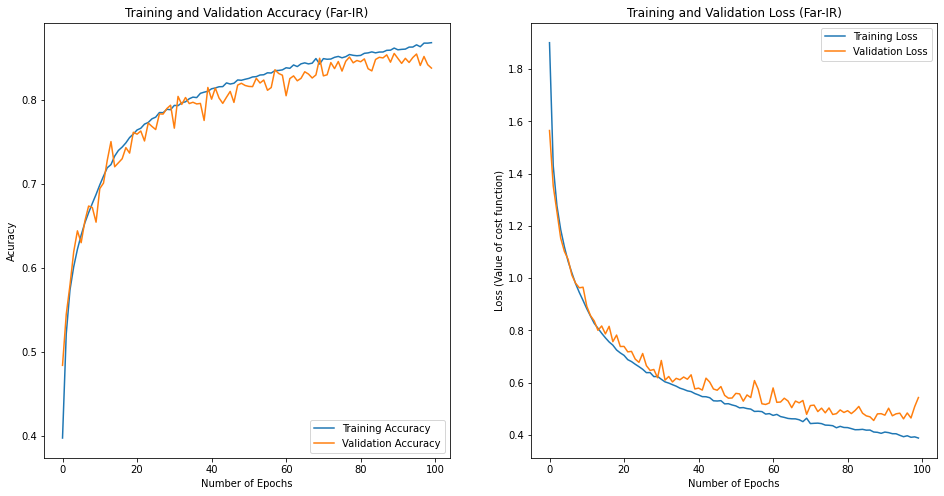

In [220]:
# Visualizing results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Far-IR)')
plt.ylabel('Acuracy')
plt.xlabel('Number of Epochs')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Far-IR)')
plt.ylabel('Loss (Value of cost function)')
plt.xlabel('Number of Epochs')
plt.show()

In [216]:
# # Save model as h5 (keras model)
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Far_IR_organic_model.h5')

In [217]:
# # Save the entire model as a SavedModel in drive
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Far_IR_organic_model') 

# Model Evaluation

In [218]:
# Model Accuracy
scores = model.evaluate(x_test, y_test, verbose=0)
print('The test Accuracy is: ', scores[1])
print('The test Loss is: ', scores[0])

The test Accuracy is:  0.8408535122871399
The test Loss is:  0.5266556739807129


In [219]:
# Classification report
y_pred = model.predict(x_test) # Whole test set
classes = encoder.classes_.tolist() # Convert our array of labels (classes) to list

predicted_categories = np.argmax(y_pred, axis=1) 
true_categories_argmax = np.argmax(y_test, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names = classes, labels = range (60) ))

                                                  precision    recall  f1-score   support

    (C10H8O4)n (Polyethylene terephthalate, PET)       0.75      0.37      0.49        49
                 (C16H14O3)n (Polycarbonate, PC)       0.70      0.36      0.48        58
  (C2ClF3)n (Polychlorotrifluoroethylene, PCTFE)       1.00      1.00      1.00         4
             (C2H3Cl)n (Polyvinyl chloride, PVC)       0.69      0.38      0.49        48
          (C2H4)n (Polyethylene, PE, HDPE, LDPE)       0.77      0.67      0.72        94
               (C2H4O)n (Polyvinyl alcohol, PVA)       0.00      0.00      0.00         0
         (C2H6OSi)n (Polydimethylsiloxane, PDMS)       0.82      0.48      0.60       298
             (C37H24O6N2)n (Polyetherimide, PEI)       0.38      0.34      0.36        41
                (C3H4O2)n (Polylactic acid, PLA)       0.00      0.00      0.00         0
     (C5H8O2)n (Poly(methyl methacrylate), PMMA)       0.86      0.78      0.82       658
         